# Dimensionality Reduction and Noise Removal of Face Images with Non-Negative Matrix Factorization

#### Candidate numbers: 10077, 10142, 10096

## Introduction

As british matematician and data scientist Clive Humby once said, "Data is the new oil. It's valuable, but if unrefined, it cannot really be used." (https://www.gwprime.geospatialworld.net/business-and-industry-trends/data-was-analytics-is-the-new-oil/). The amount of data collected and stored by big tech alone is almost incomprehensible, and it requires an incredible amount of storage space. Therefore, the abilty to effectively compress data is pivotal. In lossy data compression methods, it is often necessary to optimize for both data size after compression and having a sufficient approximation of the data. In this project we will take a closer look at how we can use one specific method, namely non-negative matrix factorization (NMF), and how we can apply it to image datasets, with and without random color and brightness variations, also called noise. The dataset we will use contains face images called CryptoPunks. The motivation for using NMF specifically, is that the resulting reduced matrices will give us information about any trends in our dataset. Before applying NMF to our images, we start by exploring the method and look at some of its properties.

## Non-negative Matrix Factorization

Mathematically, approximating a non-negative matrix $A$ as two new non-negative matrices $W$ and $H$ as accurately as we can is equivalent to solving the constrained optimization problem

$$
\min_{W,H} \|A-WH\|_F, \hskip1em \text{s.t. } W,H \text{ non-negative},
$$

where $\|\cdot\|_F$ is the Frobenius norm, which we use to calculate the "distance" between the two matrices $A$ and $WH$. The norm is defined as

$$
\|A-WH\|_F=\sqrt{\sum_{i=1}^n\sum_{j=1}^n (A-WH)_{ij}^2}.
$$

Important to know about non-negative matrix factorization is that it is a method with unknown constraints in its area of application. More specifically, it is proven difficult to determine for which matrices NMF will give good factorizations, and for which it will not, without actually applying NMF. This is also some of the motivation for this project, as we will look at some of the properties of matrices that may affect whether it is easily factored or not.

Solving the constrained optimization problem will be done numerically using an iterative algorithm proposed by Lee and Seung, as given in the project description. $W$ and $H$ are respectively $m \times d$ and $d\times n$ matrices initially consisting of random (uniformly distributed) positive numbers, which for each step are updated to better approximate out initial matrix A. The equations for calculating each step are

$$
H_{k+1}= H_k \odot (W_k^T A)\oslash (W_k^T W_k H_k)
$$
$$
W_{k+1} = W_k \odot (AH_{k+1}^T) \oslash (W_k H_{k+1} H_{k+1}^T),
$$

where "$\odot$" means elementwise multiplication and "$\oslash$" means elementwise division, as illustrated in the examples below.

$$ 
\begin{bmatrix}2 & 2 \\2 & 2 \\ \end{bmatrix} \odot\begin{bmatrix}2 & 2 \\2 & 2 \\\end{bmatrix}=\begin{bmatrix}4 & 4 \\4 & 4 \\\end{bmatrix}\hskip3em\begin{bmatrix}2 & 2 \\2 & 2 \\ \end{bmatrix}\oslash\begin{bmatrix}2 & 2 \\2 & 2 \\\end{bmatrix}= \begin{bmatrix}1 & 1 \\1 & 1 \\\end{bmatrix}
$$

There are a few things that are important to note from the algorithm equations. First of all, the only operations we perform are addition, multiplication and division. Therefore, if we assume that all matrices in step $k$ are positive, all matrices in the next step $k+1$ must also be positive, since addition, multiplication and division using only positive numbers will in turn yield positive answers. We know that $A$ is non-negative, and therefore, by initializing $W_0$ and $H_0$ (and thus also $W_0^T$ and $H_0^T$) as positive, we are guaranteed only positive iterates $W_k$ and $H_k$ for all values of k.

Additionally, we see from the definition of $H_{k+1}$ that if the matrix $V = (W_k^T A)\oslash (W_k^T W_k H_k)$ is a matrix of ones we simply end up with $H_{k+1} = H_k$, since the "$\odot$"-operator here multiplies all elements of $H_k$ by one. This is the case whenever $W_k H_k=A$ because matrix multiplication is associative, which means that $W_k^T W_k H_k = W_k^T (W_k H_k)=W_k^T A$. For this value of $W_k H_k$, V will only be a matrix of ones. $WH=A$ is therefore a fixed point for the equation. $V$ will in other words cause for the algorithm to converge, due to the fact that if an element $(W_k H_k)_{ij} < A_{ij}$, then $V_{ij}>1$ in such a way that the next value $(W_{k+1} H_{k+1})_{ij}$ is closer to $A_{ij}$ than the previous. If the algorithm converges so that the final factorization $WH=A$, we say it has reached its global minimum. In this case, the frobenius norm will converge towards 0. Since the algorithm is meant to converge, we would expect the norm to decrease for each iteration, which mathematically means that we expect the algorithm to satisfy

$$
\|A-W_{k+1}H_{k+1}\|_F \le \|A-W_k H_k\|_F,
$$

which we will come back to later on when studying the accuracy and convergence of NMF.

Before we implement the algorithm for our non-negative matrix factorization, we need to look at what happens if $W_0$ or $H_0$ are initialized as matrices containing only zeros. First of all, we would end up with a division-by-zero error, which we avoid by adding a small value $\delta=10^{-9}$ to all elements in the denominator. This, however, also affects the convergence of the algorithm, which we will discuss later. Secondly, as we see in the algorithm equations, if $H_0$ or $W_0$ only contains zeros we have a fixed point, which means all iterates $W_k$ and $H_k$ that follows will be zero as well, which obviously is not what we want. Therefore, we initialize $W$ and $H$ as matrices containing decimal numbers between 0 and 1 from a uniform distribution, by using the Numpy-function `np.random.uniform()`. This way we ensure that the initial values are random, and the probability of all values to be zero is negligible.

### Implementing and testing the NMF-Algorithm
Now we define `NMF()` and implement the non-negative matrix factorization algorithm.

In [1]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt

#!pip install opencv-python
import cv2
import os

In [2]:
def NMF(A, d, delta = 1e-9, maxiter = 1000, seed = 0, A_orig = np.zeros(1)):
    """
    Factorizes an input matrix A into two non-negative matrices W and H over
    maxiter steps, so that the error norm ||A-WH|| is minimized. Returns the factors
    W and H, as well as an array containing the error norm for each step k.
    input:
        V:       (m,n) input array
        d:       integer, number of components we want to decompose A into
        delta:   float, small number for safe division
        maxiter: integer, maximum number of iterations
        seed:    integer, random seed
    output:
        W: (m,d) array
        H: (d,n) array
        norms:   array containing the norm of each iterate
    """
    
    # if a custom seed is input, a specific set of initial values will be created
    if seed != 0:
        np.random.seed(seed)
    
    # Get matrix dimensions from A
    m = np.shape(A)[0]
    n = np.shape(A)[1]
    
    # Set initial matrices H and W
    H = np.random.uniform(0.0, 1.0, (d,n)) * np.sqrt(np.mean(A)/d) # H: (d,n) matrix
    W = np.random.uniform(0.0, 1.0, (m,d)) * np.sqrt(np.mean(A)/d) # W: (m,d) matrix
    norms = np.zeros(maxiter) # Array to contain the Frobenius norm for each step k
    
    if len(A_orig) == 1:
        norms[0] = la.norm(A-W@H, 'fro')
    else:
        norms[0] = la.norm(A_orig-W@H, 'fro')
    
    # Perform maxiter iterations to find H and W
    for k in range(1, maxiter):
        H = H * (np.transpose(W)@A) / (la.multi_dot([np.transpose(W), W, H]) + np.ones((d,n))*delta)
        W = W * (A@np.transpose(H)) / (la.multi_dot([W, H, np.transpose(H)]) + np.ones((m,d))*delta)
        
        if len(A_orig) == 1:
            norms[k] = la.norm(A-W@H, 'fro')
        else:
            norms[k] = la.norm(A_orig-W@H, 'fro')
    
    return W, H, norms

In order to test the algorithm, we first use two different matrices and analyze the outputs. The two matrices are

$$
A_1 = \begin{bmatrix}1 & 0 \\0 & 1 \\\end{bmatrix}\hskip1em A_2 =\begin{bmatrix}1&2\\1&1\\1&2\\ \end{bmatrix}.
$$

For this section we use $maxiter=1000$, which should be sufficient for the algorithm to converge completely, as the matrices are small. If they do, we expect the end norms to be the same for a given matrix regardless of initial $W$ and $H$, since the global minimum of the norm is dependent on the matrix $A$, not the initial $W$ and $H$. However, if the matrices are large or the total iterations too few, the end norm may vary a lot depending on the initial value. This is because the NMF algorithm may get stuck at a so called local minimizer, where any "nearby" matrix has a higher norm than the one at the local minimum, so that it stays at this value even though it is not the global minimum. Therefore it is important to run NMF multiple times with different initial values to see whether this is the case, and if so consider increasing $maxiter$.

We start by using $d=1$. This means that $W$ consists of one column and $H$ consists of one row. We then find $W$, $H$, $WH$ and $\|A-WH\|_F$ for each matrix with two different initial values.

In [3]:
# Initialize A1 and A2
A1 = np.identity(2)
A2 = np.array([[1,2], [1,1], [1,2]])

# Get W and H for A1 and A2, d = 1, twice
W_11, H_11, norms_11 = NMF(A1, 1, seed=2)
W_12, H_12, norms_12 = NMF(A1, 1, seed=3)
W_21, H_21, norms_21 = NMF(A2, 1, seed=2)
W_22, H_22, norms_22 = NMF(A2, 1, seed=3)

$A$               | $W$             |      $H$             |      $WH$      |      $\|A-WH\|_F$
:----------------:|:---------------:|:--------------------:|:--------------:|:----------------:
$$ \begin{bmatrix}1&0\\0&1\\ \end{bmatrix}$$|$$\begin{bmatrix}0.389\\0.308\\ \end{bmatrix}$$|$$ \begin{bmatrix}1.581&1.252\\ \end{bmatrix}$$|$$ \begin{bmatrix}0.615&0.487\\0.487&0.385\\ \end{bmatrix}$$|$1$
$$ \begin{bmatrix}1&0\\0&1\\ \end{bmatrix}$$|$$\begin{bmatrix}0.206\\0.361\\ \end{bmatrix}$$|$$ \begin{bmatrix}1.190&2.091\\ \end{bmatrix}$$|$$ \begin{bmatrix}0.244&0.430\\0.430&0.755\\ \end{bmatrix}$$|$1$
$$ \begin{bmatrix}1&2\\1&1\\1&2\\ \end{bmatrix}$$|$$\begin{bmatrix}0.624\\0.381\\0.624\\ \end{bmatrix}$$|$$ \begin{bmatrix}1.762&3.113\\ \end{bmatrix}$$|$$ \begin{bmatrix}1.100&1.943\\0.671&1.186\\1.100&1.943\\ \end{bmatrix}$$|$0.411$
$$ \begin{bmatrix}1&2\\1&1\\1&2\\ \end{bmatrix}$$|$$\begin{bmatrix}0.882\\0.538\\0.882\\ \end{bmatrix}$$|$$ \begin{bmatrix}1.247&2.202\\ \end{bmatrix}$$|$$ \begin{bmatrix}1.100&1.943\\0.671&1.186\\1.100&1.943\\ \end{bmatrix}$$|$0.411$

As explained, the goal of the NMF-algorithm is to create a factorization $WH\approx A$. What we see from the table, however, is that $A$ and $WH$ are quite different, which simply is due to the fact that having only one dimension in $W$ and $H$ is insufficient to represent $A$ precisely. This is confirmed by the high value of the Frobenius norm. We can safely conclude that the algorithm seems to have converged, as the norm is the same for both initial conditions, which implies that the relatively large norm is solely due to the low value of $d$.This also means that our $maxiter$ is sufficiently large. For instance, we see that $\|A_1 - WH\|_F$ always equals 1. The fact that we get different output matrices for different initial conditions even though $A$ is the same shows the non-unique feature of NMF, as different results for $WH$ have the same norm and are equally good solutions to the problem.

From the table we also see that there are some obvious similarities, which implies that the algorithm is doing what we want it to. First of all, we see in the factorization of $A_2$ that the first and last value of $W$ and of each column in $WH$ is equal, which is similar to the original $A_2$. There are less similarities between $WH$ and $A$ for $A_1$, which is why the norm is higher.

The main problem with using $d=1$, is that it cannot represent $A$ accurate enough. Therefore when $d$ increases, we would expect  $A$ and its approximation to be more similar. To test this, we repeat the experiment for one initial value per matrix, but with $d=2$.

In [4]:
# Get W and H for A1 and A2, d = 2
W_1, H_1, norms_1 = NMF(A1, 2, seed=2)
W_2, H_2, norms_2 = NMF(A2, 2, seed=2)

$A$               | $W$             |      $H$             |      $WH$      |      $\|A-WH\|_F$
:----------------:|:---------------:|:--------------------:|:--------------:|:----------------:
$$ \begin{bmatrix}1&0\\0&1\\ \end{bmatrix}$$|$$\begin{bmatrix}0.470&0\\0&0.359\\ \end{bmatrix}$$|$$ \begin{bmatrix}2.126&0\\0&2.789\\ \end{bmatrix}$$|$$ \begin{bmatrix}1&0\\0&1\\ \end{bmatrix}$$|$5.914\cdot10^{-10}$
$$ \begin{bmatrix}1&2\\1&1\\1&2\\ \end{bmatrix}$$|$$\begin{bmatrix}0.267&0.448\\0.520&0.193\\0.267&0.448\\ \end{bmatrix}$$|$$ \begin{bmatrix}1.405&0.344\\1.395&4.264\\ \end{bmatrix}$$|$$ \begin{bmatrix}1&2\\1&1\\1&2\\ \end{bmatrix}$$|$9.571\cdot10^{-10}$

As expected, the matrix representation is way better for $d=2$. The fact that the norm is so small, implies that the algorithm is able to factorize $A$ almost perfectly, which obviously is because we are using twice as many numbers to represent the matrix. Using this many, however, is very impractical when it comes to image representation as we are using more data points for $W$ and $H$ than for the original matrix. Therefore, in order for NMF to be of any practical use, one must try to find a middle ground between accuracy and minimizing datapoints. We will take a look at this later in the report when analyzing the CryptoPunk images.

### Accuracy and Convergence of NMF

As mentioned earlier, we measure the difference between $WH$ and $A$ by using the Frobenius norm. Now, we will use this norm to study the accuracy of NMF by looking at how it is affected by $d$.  First, let us take a look at the matrix rank, as this might give a better understanding of what values of $d$ gives the best convergence. In this section we look solely at the two matrices

$$
A_3=\begin{bmatrix}2&1&1\\2&1&1\\1&1&2\\ \end{bmatrix}\hskip1em A_4=\begin{bmatrix}2&1&0\\1&2&3\\0&3&3\\ \end{bmatrix}.
$$

To find the matrix rank, we use the numpy linalg function `np.linalg.svd()`, which returns the singular value decomposition (SVD) of $A$. Without going into too much details about SVD, it is a way of factorizing diagonalizable matrices into three new matrices, $A=U\Sigma V^T$, which can be used to remove redundant information in the case where any singular values of $A$ are zero. Out of the returned arrays, we are interested in looking at $\Sigma$, which is a rectangular, diagonal matrix containing all the singular values of $A$. To avoid floating point error (computer error) we find the number of values larger than $10^{-12}$, as floating point errors usually are of magnitude $10^{-14}$. The number of singular values not equal to zero equals the matrix rank.

In [5]:
# Initialize A3 and A4 
A3 = np.array([[2,1,1], 
               [2,1,1], 
               [1,1,2]])
A4 = np.array([[2,1,0], 
               [1,2,3], 
               [0,3,3]])

# Find the rank
A3_rank = np.size(np.where(la.svd(A3)[1] > 1.e-12))
A4_rank = np.size(np.where(la.svd(A4)[1] > 1.e-12))
print(f"The rank of A3 is {A3_rank}")
print(f"The rank of A4 is {A4_rank}")

The rank of A3 is 2
The rank of A4 is 3


We find that $\text{rank}(A_3)=2$ and $\text{rank}(A_4)=3$, which means that the columns of matrix $A_3$ are linearly dependent, while those of $A_4$ are not. This implies that one of the columns in $A_3$ carry unnecessary information, as we already get the same information from a linear combination of the other two, and we would therefore expect $d=2$ to be sufficient for a good recreation $WH\approx A_3$. For matrix $A_4$, on the other hand, a rank of 3 implies that all columns carry unique information, and thus we would expect $d=3$ to give the most accurate result. Let us now plot the norm, $\|A-WH\|_F$, as a function of iteration steps, $k$, for both $A_3$ and $A_4$.

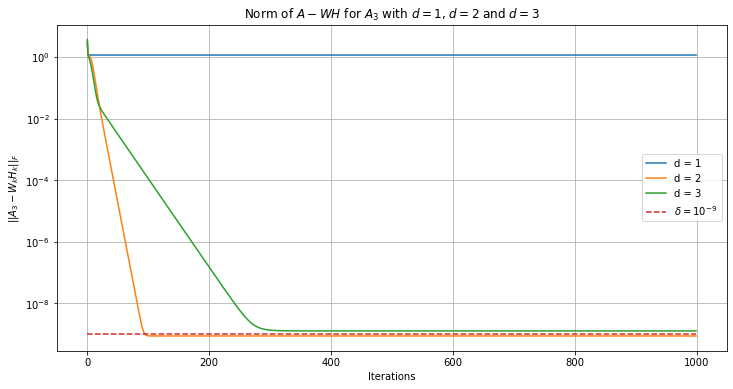

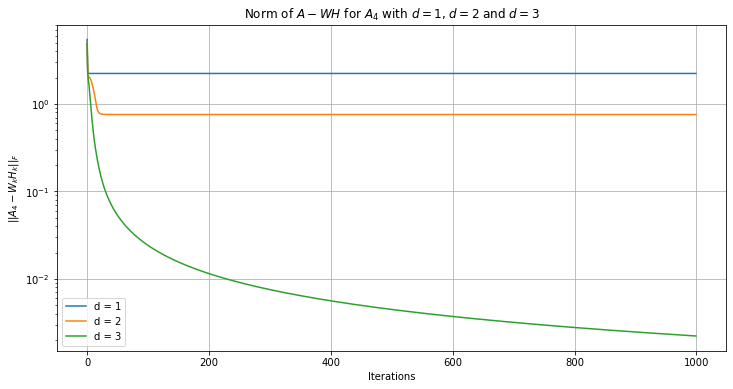

In [9]:
# Getting outputs for A3
W_31, H_31, norm_31 = NMF(A3, 1) # d = 1
W_32, H_32, norm_32 = NMF(A3, 2) # d = 2
W_33, H_33, norm_33 = NMF(A3, 3) # d = 3

# Getting outputs for A4
W_41, H_41, norm_41 = NMF(A4, 1) # d = 1
W_42, H_42, norm_42 = NMF(A4, 2) # d = 2
W_43, H_43, norm_43 = NMF(A4, 3) # d = 3

# Array of all k, array with delta
k = np.arange(0, np.size(norm_43), 1) # Array with iteration numbers, k
delta_array = np.ones(len(k))*10**-9

# Plot for A3
plt.figure(figsize=(12,6))
plt.semilogy(k, norm_31)
plt.semilogy(k, norm_32)
plt.semilogy(k, norm_33)
plt.semilogy(k, delta_array, '--')
plt.grid()
plt.title(r"Norm of $A-WH$ for $A_3$ with $d = 1$, $d = 2$ and $d = 3$")
plt.xlabel("Iterations")
plt.ylabel(r"$||A_3-W_k H_k||_F$")
plt.legend(["d = 1", "d = 2", "d = 3", "$\delta=10^{-9}$"])
plt.show()

# Plot for A4
plt.figure(figsize=(12,6))
plt.semilogy(k, norm_41)
plt.semilogy(k, norm_42)
plt.semilogy(k, norm_43)
plt.grid()
plt.title(r"Norm of $A-WH$ for $A_4$ with $d = 1$, $d = 2$ and $d = 3$")
plt.xlabel("Iterations")
plt.ylabel(r"$||A_4-W_k H_k||_F$")
plt.legend(["d = 1", "d = 2", "d = 3"])
plt.show()

The first thing to notice in both plots is that all curves are all strictly decreasing, which implies that the inequality $\|A-W_{k+1}H_{k+1}\|_F \le \|A-W_k H_k\|_F$ mentioned earlier is satisfied. By running the plots several times, however, we could on a rare occasion see a positive shift in the upper plot for $d = 2$ and $d = 3$ once the norm reached $\|\cdot\|_F\approx 10^{-9}$, which we assume is due to the constant $\delta$ that we added to the denominator in the NMF-algorithm. Since all elements of $A_3$ and $A_4$ are of magnitude $m_A\approx1$, all iterates $H_k$ and $W_k$ will be of magnitude $m_H\approx\sqrt{m_A}\approx1$, and thus adding $\delta=10^{-9}$ to the denominator in our equation of $H_k$ results in an error $\frac{\delta}{m_H}\approx10^{-9}$ for our approximation $W_kH_k$. This is clearly shown in the first plot (for $A_3$), where the curves for $d=2$ and $d=3$ are forced to converge at $\|A-W_k H_k\|\approx10^{-9}$, which may cause for the curve to act a bit weird around this value.

The second thing we can see is that the norms of $A_3$ and $A_4$ converge to values of very different magnitude. Whereas $d=2$ is sufficient in order for the NMF of $A_3$ to converge to a norm of $10^{-9}$, $d=2$ causes the NMF of $A_4$ to converge to about $10^{-0.2}$. For $d=3$ we expect the algorithm to converge towards $10^{-9}$ as well, as the dimensions of $W$ and $H$ are equal to those of $A_4$, but it clearly takes way more iterations. This difference in convergence may be a result of the difference in rank between the two, as the rank of $A_4$ being higher means that it contains more unique information, and thus is more difficult to represent. But, as the difference is so big, the difference in convergence might simply be an example that shows how uncertain NMF can be, as we do not have a complete understanding of which matrices it works well for, and which ones it does not.

A third interesting thing to look at is that the norm seems to converge the fastest whenever $d= \text{rank}(A)$. In both plots, with $d=1$, the algorithm converges to a relatively large error, which simply is due to the fact that having one dimension in $W$ and $H$ is insufficient to represent $A$ accurately, regardless of the initial value. This is coherent with what we discovered when analyzing and comparing $WH$ to $A$ for $A_1$ and $A_2$. We also see that a higher $d$ not necessarily means a faster convergence, as $d=2$ clearly is more efficient than $d=3$ in the upper plot. By running the code several times, we also noticed that the $d=3$ curve varies more, and can take anywhere between 100 and several thousand iterations to converge. Nonetheless, both $d=2$ and $d=3$ is sufficient to reach the limit precision of $\|A-WH\|_F\approx\delta$, and a reason for $d=2$ most of the times converging faster can therefore be that $d=3$ is more dependent on the initial value, and can take more or less iterations than $d=\text{rank}(A)$ depending on the starting point. Our conclusion regarding the relation between $d$ and $\text{rank}(A)$ for these matrices is therefore that in order to reach a global minimum of $\|A-WH\|_F\approx \delta$, $d$ has to be greater than or equal to the rank of $A$, but that the number of iterations required to reach this minimum can vary a lot depending on $d$, the matrix $A$ and the initial factors $W_0$ and $H_0$.

## Applying NMF to CryptoPunks

We now shift our focus to applying NMF as a way of decomposing a set of images into discrete image components. Our set will consist of 10.000 different CryptoPunks; a Non Fungible Token (NFT) collection. For this project, we are solely interested in the digital art which represent these CryptoPunks tokens and not their role as a form of digital currency. Each CryptoPunk character is a 24 x 24 RGBA image, which makes up a unique character within our dataset. Each pixel in our image will have a non-negative value representing the amount of red, green and blue (RGB), which in this project be values in the interval [0,1]. Furthermore, all pixels will have a value of either 0 or 1 representing the opacity of that pixel; 0 being no opacity and 1 being complete opacity. Pixels that make up our character will have an opacity value of 0. 

Although all characters in our dataset are unique, some traits will be shared between different characters. Examples of traits can be a certain face shape or headgear, where these traits will vary in rarity; some occur more frequently in our dataset than others. Still, traits will occupy the same set of pixels regardless of which character it is placed on, which is pivotal for our use of NMF. If our dataset were to contain shared traits located on <em>different </em> sets of pixels, NMF would not be applicable. In our decomposition of our dataset, we can therefore separate our dataset into a unique set of traits, which in turn can be used to recreate each CryptoPunk as a sum of their respective traits. 

### CryptoPunks as RGBA images

Before using the NMF algorithm on CryptoPunk images, we need to understand what the punks look like and how they are represented by matrices with RGBA values. We implement the two functions `load_images()` and `plotimgs()`, which we use respectively to load images from our dataset and to plot them.

In [7]:
def load_images(N):
    """
    Loads images from cryptopunk dataset. The loading order is deterministic,
    so for a certain N the exact same images will be loaded. 
    Input:
        N, integer, number of images to load
    Output:
        faces, (24,24,4,N) numpy array containing images
    """
    # Allocate array to store images
    faces = np.zeros((24,24,4,N))

    # Iteration variable
    i = 0

    # Iterate over folders
    for subdir, dirs, files in os.walk('./imgs'):

        # Iterate over files
        for file in files:

            # Filepath to load from
            filepath = subdir + os.sep + file

            # Make sure that the file is a .png
            if filepath[-3:] == 'png':

                # Load the image
                im = cv2.imread(filepath, cv2.IMREAD_UNCHANGED)

                # Convert it to RGBA and rescale pixels
                faces[:,:,:,i] = cv2.cvtColor(im, cv2.COLOR_BGRA2RGBA)/255.0

                i+=1
            if i == N:
                break
    return faces

# Number of faces to keep in final array
N = 500

# Load all 10000 images
faces = load_images(10000)

# Select N random images
choices = np.random.choice(faces.shape[-1],N, replace = False)
faces = faces[:,:,:,choices]

In [8]:
# Code for plotting images
def plotimgs(imgs, title, color="k", nplot = 8, rescale = False, filename = None):
    """
    Plots nplot*nplot images on an nplot x nplot grid. 
    Saves to given filename if filename is given
    Can also rescale the RGB channels
    input:
        imgs: (24,24,4,N) or (24,24,3,N) array containing images, where N > nplot**2
        nplot: integer, nplot**2 images will be plotted
        rescale: bool
        filename: string, figure will be saved to this location. Should end with ".png".
    """
    # We will change some of the parameters of matplotlib, so we store the initial ones
    oldparams = plt.rcParams['figure.figsize']

    # New params to make better plot. There definitely exists better ways of doing this
    plt.rcParams['figure.figsize'] = (16, 16)

    # Initialize subplots
    fig, axes = plt.subplots(nplot,nplot)

    # Set background color
    plt.gcf().set_facecolor("lightgray")

    # Iterate over images
    for idx in range(nplot**2):
        
        # Indices
        i = idx//nplot; j = idx%nplot

        # Remove axis
        axes[i,j].axis('off')

        # Rescale RGB channels by dividing my maximal value
        if rescale:
            scaled_img = np.copy(imgs[:,:,:,idx])
            scaled_img[:,:,:3] = scaled_img[:,:,:3]/np.max(scaled_img[:,:,:3])
            axes[i,j].imshow(scaled_img)
        else:
            axes[i,j].imshow(imgs[:,:,:,idx])
    
    # Tight layout so images will appear closer together
    plt.tight_layout()
    
    fig.suptitle(title, fontsize = 22, color = color)
    
    # Save if filename is given
    if filename is not None:
        plt.savefig(filename)

    plt.show()

    # Return to old parameters
    plt.rcParams['figure.figsize'] = oldparams

As well as defining the functions, we have now loaded all 10'000 images. To test we plot a grid of $8\times 8$ subplots.

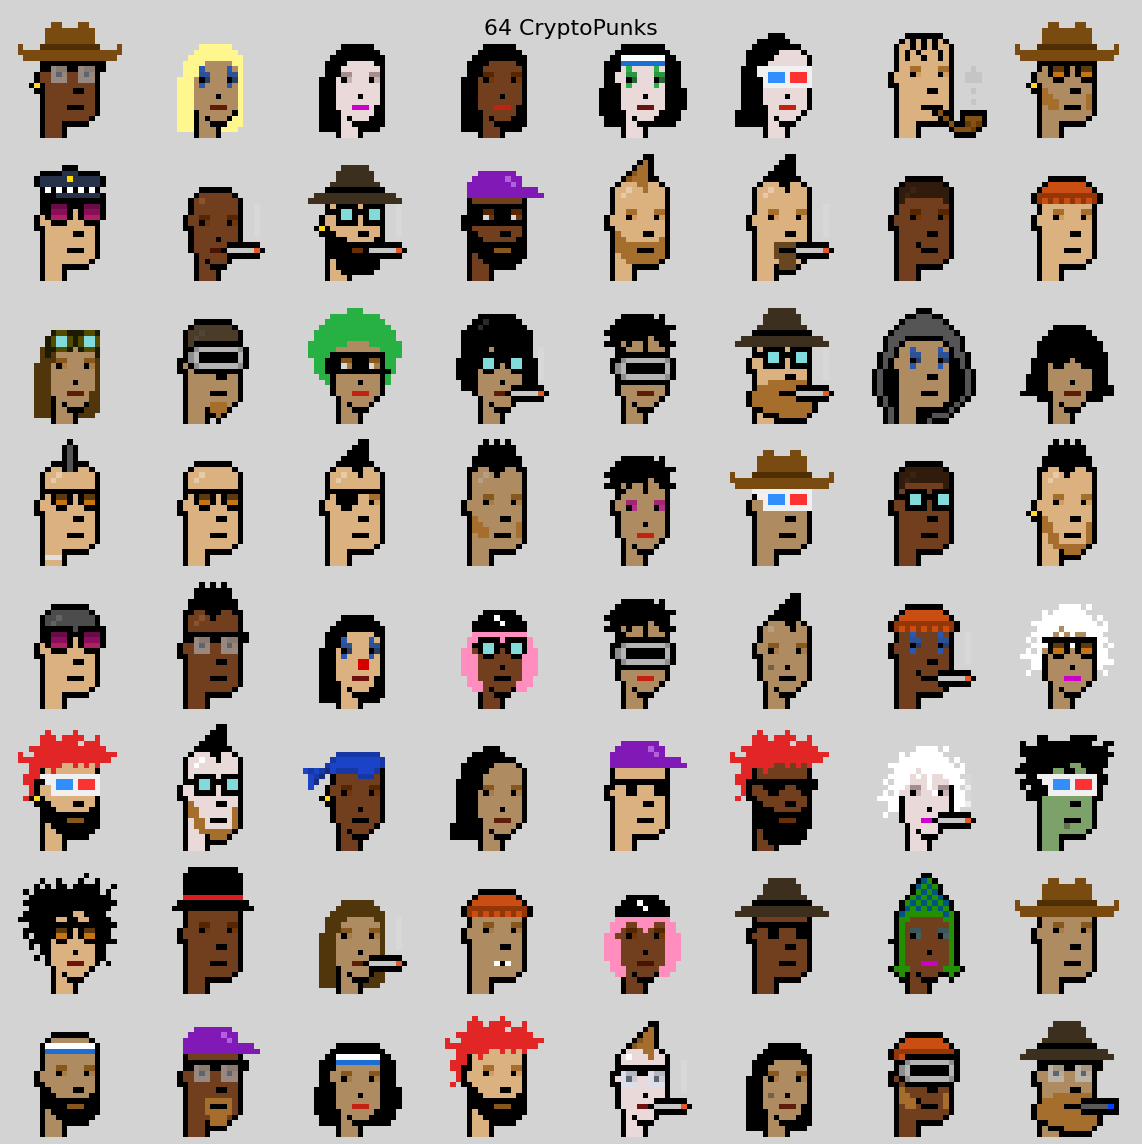

In [9]:
# Example of plotting 8 times 8 images stored in "faces" and saving the output to a file named "punks.png"
plotimgs(faces, "64 CryptoPunks", filename="punks.png")

From our subplots above, we see a subset of our 10'000 CryptoPunks. As we can see, these characters will have some shared traits, all the while none of them are exactly alike. Our intent will be to discover the image components from these characters, while gaining a deeper understanding of how to best approximate these characters using NMF. We start by separating the RGB- and opacity-channels. 

In [10]:
# Split the images into opacity and rgb channels
faces_opacity = faces[:,:,3,:]
faces_rgb = faces[:,:,:3,:]
shape = faces_rgb.shape

# Clever reshape "trick". This is the matrix we will apply the NMF to
faces_reshaped = faces_rgb.reshape(np.prod(shape)//N, N)

Since all our traits (and therefore also our entire dataset) only consists of different sets of RGBA values for each pixel, it is possible to find a <em>mean image</em> of our dataset. Analysing such an image might give us some insight in some of the commonalities between images in our dataset.

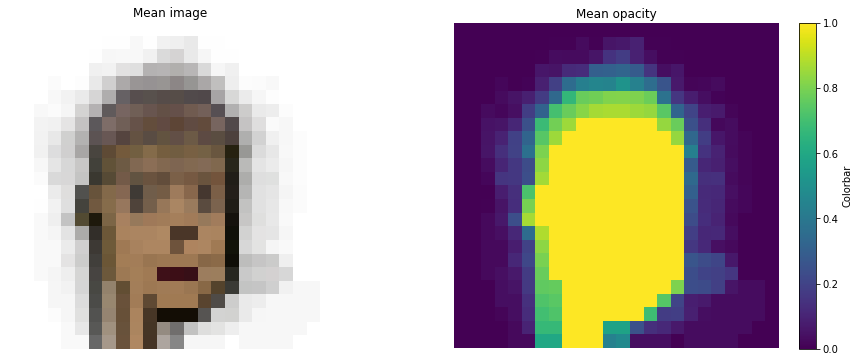

In [11]:
rgba_means = np.zeros((24,24,4))
for color in range(4):
    for i in range(24):
        for j in range(24):
            pixel = faces[i,j,color,:]
            mean = np.mean(pixel, axis = -1)
            rgba_means[i,j,color] = mean

plt.subplots(2,1, figsize=(16,6))

# Plot mean image
ax = plt.subplot(1, 2, 1)
ax.axis("off")
ax.imshow(rgba_means)
plt.title("Mean image")

# Plot mean opacity
ax = plt.subplot(1,2,2)
ax.axis("off")
im = ax.imshow(rgba_means[:,:,3])
plt.title("Mean opacity")

# Make colorbar
bar = plt.colorbar(im)
bar.set_label('Colorbar')

plt.show()

Looking at the resulting image, we can see that there seems to be some predominant traits within the dataset. Given that our resulting image is a mean from all our sampled images, a clear trait in our mean image implies a certain commonality among our sampled images. Consequently, we can especially see that some parts of the face, as well as the shape of both mouth and nose seems to be pretty common among all CryptoPunks. Other features such as headgear, eyewear and hairstyle seem to be more varying, as they appear more <em>blurry</em> in our mean image. This is as expected, as traits such as headwear often vary in both color and size, while most CryptoPunks have a very similar mouth and nose.

We can also infer from our mean image which pixels are transparent; the pixels that make up the background in our images. This becomes the most apparent from the rightmost plot, which shows the mean opacity for each pixel. From this plot, we can see that there is a set of pixels making a "face shape", in which all pixels have opacity 1. This implies that all CryptoPunks have some sort of non-transparent pixel in this area, which makes up the faces of the CryptoPunks. Likewise, there seems to be some area in the background surrounding the CryptoPunks where the pixels appear transparent for all images, with RGB-values equal to 0 for all images. These pixels will as a consequence be suitable to data compression when NMF is applied, as they repeat throughout our dataset. This becomes evident when looking at the rank of the matrix which holds our images:

In [12]:
# Calculates rank of matrix with SVD, prints result
print("Rank of matrix: ", np.size(np.where(la.svd(faces_reshaped)[1] > 1.e-12)))

Rank of matrix:  385


When discussing the rank of our matrix, we are essentially asking how many images we need to recreate all the images in our dataset. Phrased differently, we are interested in the number of linearly independent column vectors for our matrix. We know from basic linear algebra that a M x N matrix will have a rank that can be no higher than min(M,N). With M = 1728 and N = 500, we can therefore have a maximum rank of 500 for our matrix. Acknowledging that our matrix contains data for N = 500 images, we can see that our matrix rank is significantly lower than N.
We can attribute this to the similarities between our images. 

Firstly, having a shared background for all images is effectively having less rows in our matrix, as there is less data that can vary between images. We do not have to worry about such values when considering linear combinations of column vectors, as they are always zero for all images. Secondly, shared traits between our characters further adds to the linearly dependence between column vectors (images) in our matrix. We can demonstrate these two effects using a simplified representation of our matrix. As an example we analyse a set of 2 x 2 RGB images, where our dataset contains data for three non-identical images.

\begin{bmatrix}
0 & 0 & 0\\
0 & 0 & 0\\
0 & 0 & 0\\
0.2 & 0.2 & 0.4\\
0.3 & 0.3 & 0.6\\
0 & 0 & 0\\
0.2 & 0.3 & 0.5\\
0 & 0 & 0\\
0 & 0 & 0\\
0 & 0 & 0\\
0.1 & 0.1 & 0.2\\
0 & 0 & 0\\
\end{bmatrix}

In [13]:
example_matrix = np.array([[0,0,0,0.2,0.3,0,0.2,0,0,0,0.1,0],
                           [0,0,0,0.2,0.3,0,0.3,0,0,0,0.1,0],
                           [0,0,0,0.4,0.6,0,0.5,0,0,0,0.2,0]]).T

In [14]:
# Prints rank of example matrix found using SVD
print("Rank of example matrix: ",np.size(np.where(la.svd(example_matrix)[1] > 1.e-12)))

Rank of example matrix:  2


We can see from our idealized example that the color value for the first pixel (with its RGB-values in the first three rows)  is set to zero for all columns in our matrix. This represents a non-colorized pixel; a shared background for our 2 x 2 images. Furthermore, the first and second column in our matrix share values for the second and fourth pixel, although they are not completely identical. This is a simplified representation of the CryptoPunks shared traits. Although these columns are representing two different images, we can see that they combined make the third column. That is, the third column is linearly dependent of the first two and the rank of our matrix therefore equals 2. Notice that the image represented by the third column will have no shared colors with the first two! Still, a recreation of the third image in our dataset is possible only using a linear combination of our first two images. 

Although our actual dataset contains far more data than this example, the ratio between number of columns and rows is roughly the same in our example and our actual matrix. We can therefore assume that our arguments also are valid for our actual matrix containing our images, as they were for our example.

### Applying NMF

Keeping in mind our discussion on the connection between matrix rank and chosen dimension $d$, we now apply the NMF algorithm to our matrix. We then analyse the resulting matrix $W$, here with $d=64$. Our focus is on finding the underlying common features, also called <em> clusters, </em> of our dataset. Since we possibly can have values in $W$ that are greater than 1 in our reshaped matrix, we clip our resulting matrix such that all values are in the interval $[0,1]$. 

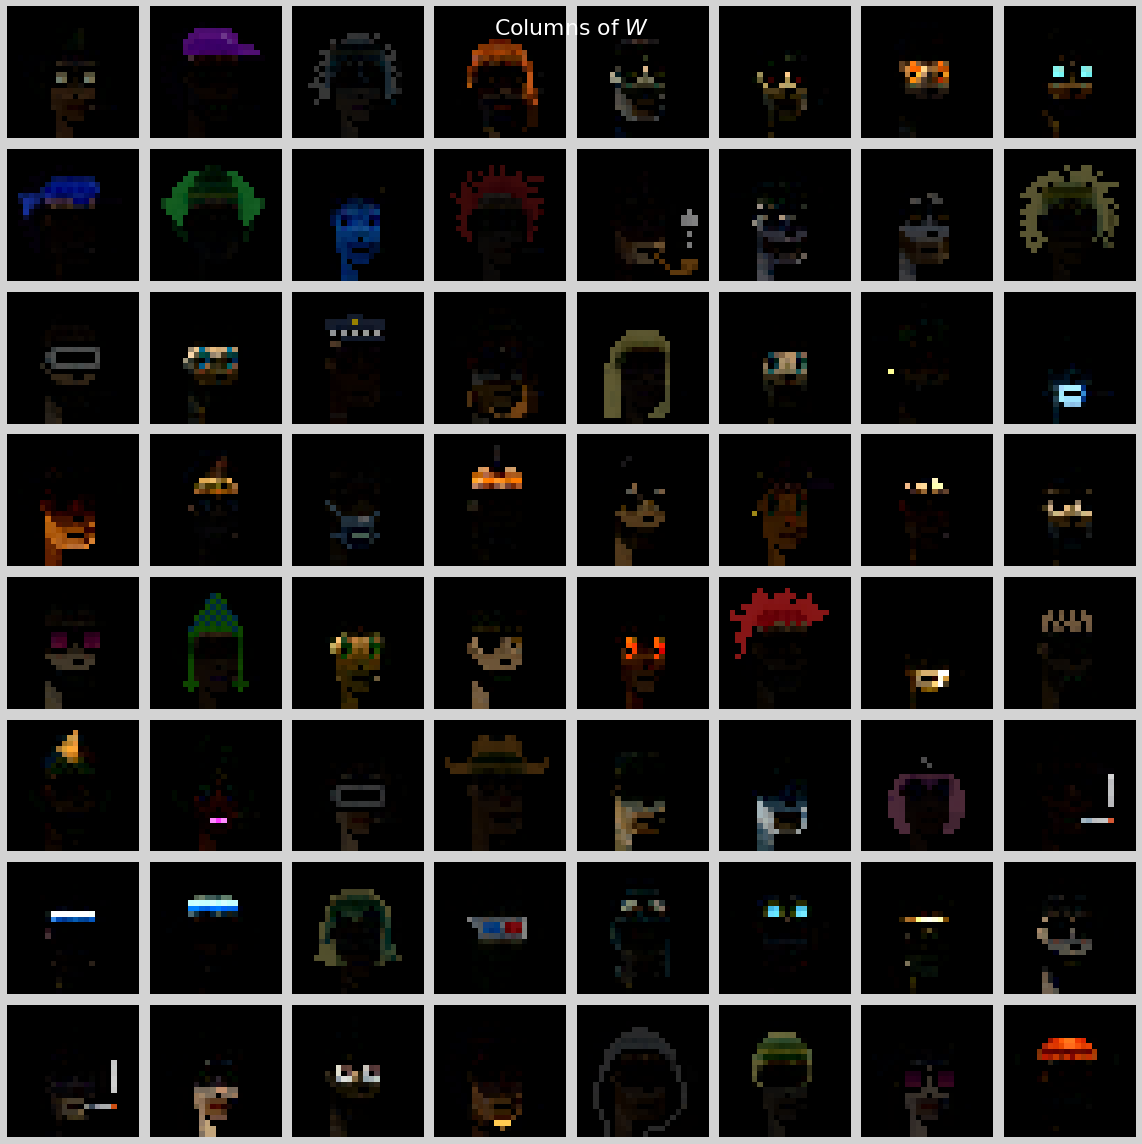

In [15]:
d = 64
NMF_faces = NMF(faces_reshaped,d)[0]
NMF_faces_reshaped = np.clip(NMF_faces.reshape(24,24,3,d),0,1)
plotimgs(NMF_faces_reshaped, "Columns of $W$", "w")

When plotting each column in $W$, we can see that the application of NMF seems to have deconstructed our images into a set of vectors which predominantly contain isolated traits. Here, the columns of $W$ represent an approximation of the basis-vectors of our matrix; this derived from the fact that all CryptoPunks only are a sum of a given set of traits. As we will demonstrate later, these columns can in turn be used to reconstruct our characters with some error margin. Evident from these column vectors is that some traits seem to be more easily isolated than others, which manifests as distinct clusters. Generally speaking, clusters representing traits of some solid color seem to be more distinct with NMF than traits that have somewhat faint colors. Still, the majority if not all of our found clusters have some sort of "impurities". This becomes most apparent when looking at the "faces", as these are generally poor approximations of our CryptoPunks, showing that a linear combination of multiple "facial" basis-vectors is needed to adequately reconstruct any character's face.

By altering the number of basis-vectors we use in $W$, namely the value of $d$, we can effectively alter the number of data points available for our decomposition-matrices $W$ and $H$. Here we wish to lose as little data as possible in our approximation of our matrix, all the while minimizing the amount of data points needed to represent our dataset. Remembering our previous discussion about $d$ and how it affects our approximation, there would seem to be a value of $d$ which optimally deconstructs our data. A natural upper bound is formed by looking at for what value of $d$ we have equal amounts of datapoints in $W$ and $H$ combined, as in our matrix. 

$$
1728 \times 500 = d \times 500 + 1728 \times d \Rightarrow d \approx 388
$$

With d = 388, we store roughly the same amount of datapoints as before, giving us no compression of our original matrix. This serves as a natural upper bound for our d-value, as we clearly want some data-compression in our use of NMF.

### Reconstructing images

After performing NMF, we can calculate a reconstructed $A$ from $A_{rec} = WH$ where $W$ and $H$ are the output matrices from NMF. Earlier, we sorted out the opacity channel from the images, and stored the values in variable (faces_opacity). We can now add the opacity values into our reconstructed matrix, $A_{rec}$, using the np.insert() function. With all this we will now be able to plot our dimensionally reduced data similarly to our original data and compare.

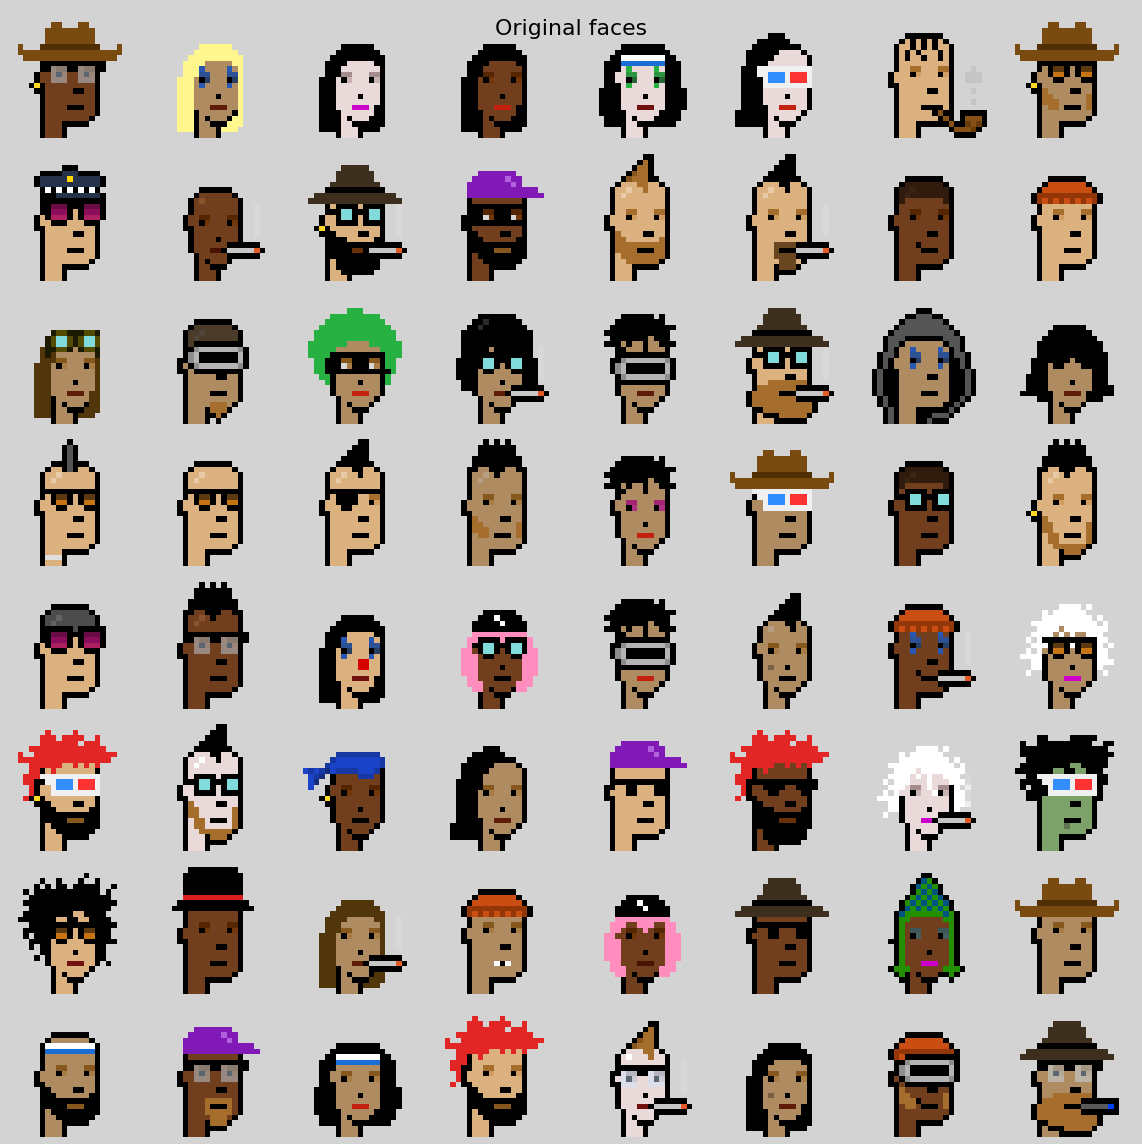

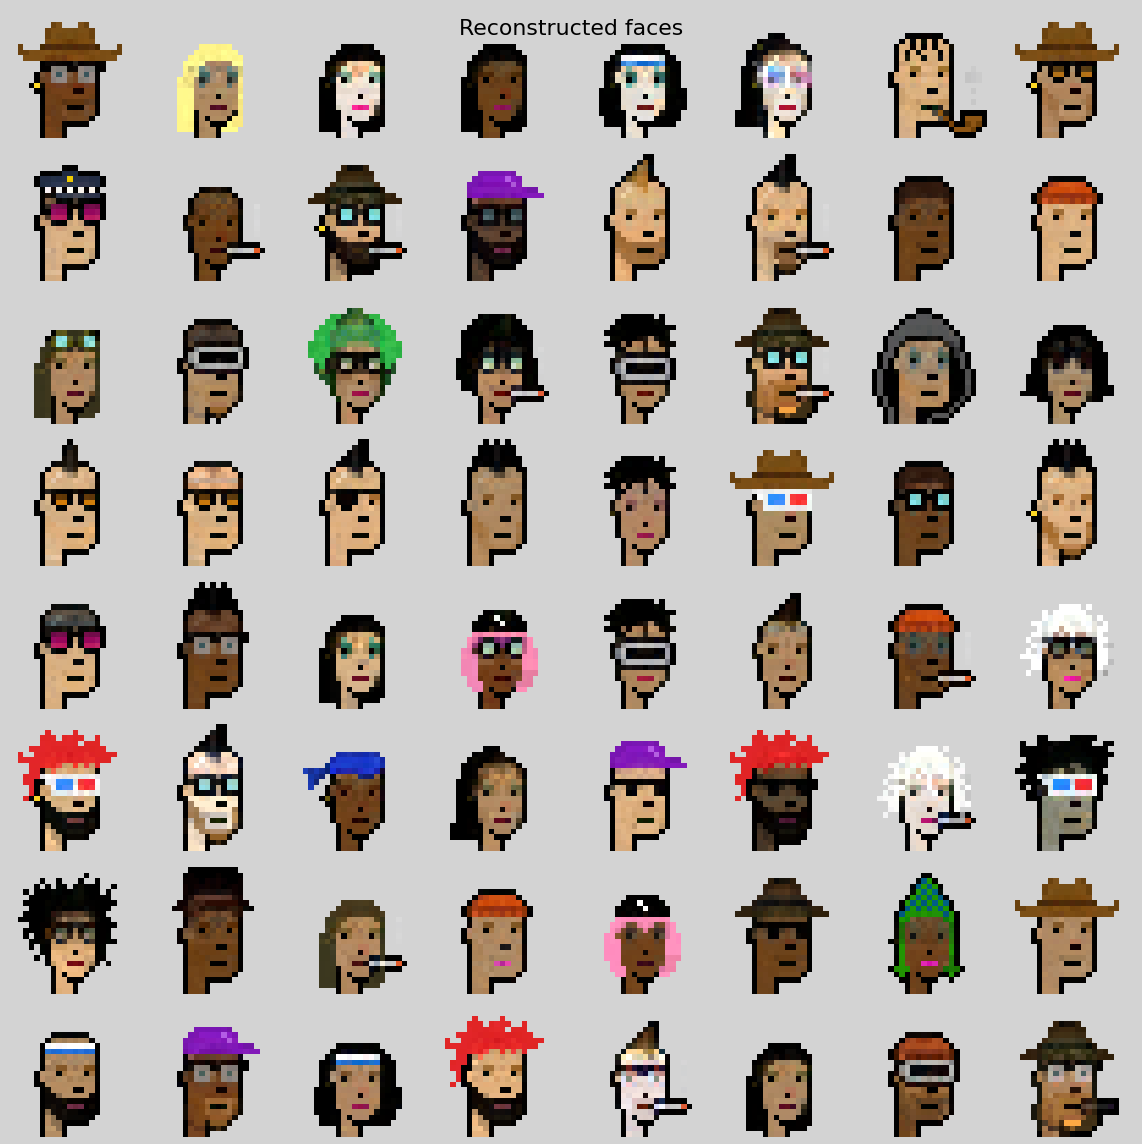

In [16]:
d = 64
result = NMF(faces_reshaped,d)
A_rec = result[0] @ result[1]
punks_rec = np.clip(A_rec.reshape(24,24,3,N),0,1)
punks_rec_opa = np.insert(punks_rec, 3, faces_opacity, axis = 2)

plotimgs(faces, "Original faces")
plotimgs(punks_rec_opa, "Reconstructed faces")

The first $8 \times 8$ grid is the same as before, the second one contains the reconstructed faces. Overall, the reconstructions look pretty good, considering we have reduced a $1728 \times 500$ matrix into a $1728 \times 64$ matrix and a $64 \times 500$ matrix. That means we have reduced the number of datapoints from $864'000$ to $142'592$, a reduction of approximately $83.5$%. This big of a reduction obviously leads to some error, corresponding to the "noise" in the cryptopunks faces. Additionally, we only ran the NMF algorithm for $\text{maxiter} = 1000$ steps. We remember from earlier that it is not always easy to predict how fast the algorithm converges for a given matrix. In other words, we can not yet conclude that the algorithm has reached a minima.

Looking at the reconstructions it seems that distinct traits are generally recreated very clearly. For instance, observe the blue bandana, the purple cap, the red hair or the hoodie. Other less distinct features such as beard, eye make-up or smiles are not reconstructed that well. The beard often gets mixed into skin tones and the eye make-up often just ends up as a dark blur. Also attributes that are similar can get mixed up. For instance the green clown hair and the green hat appear to be intertwined in characters that originally only have the clown hair.

Rare features are also reconstructed less accurately. For example the green zombie turns kind of greyish. From the cryptopunk creators' website (https://www.larvalabs.com/cryptopunks) we find that only 88 of the 10'000 characters are zombies. In comparison approximately one third of the punks have dark skin, and from the plot we observe that this skin tone is much more accurately represented.

### Error and convergece of reconstructions

To further investigate the results of the NMF algorithm we can plot the difference between $A$ and $WH$ for each step, using the Frobenius norm as earlier. We do this for different values of $d$, that is the amount of columns in $W$. The details of this were discussed earlier. We remember that as long as we stay below the rank the norm should converge faster for smaller $d$, but more accurately for larger $d$. Using the same functions as earlier, we can find the rank of $A$.

In [17]:
print("Rank of A:",np.size(np.where(la.svd(faces_reshaped)[1] > 1.e-12)))

Rank of A: 385


If we look at the development of the norm for $d \in [16, 32, 64]$, these values are way below the rank of the matrix. Hence, we expect the plot to behave quite nicely, bearing in mind the results from earlier.

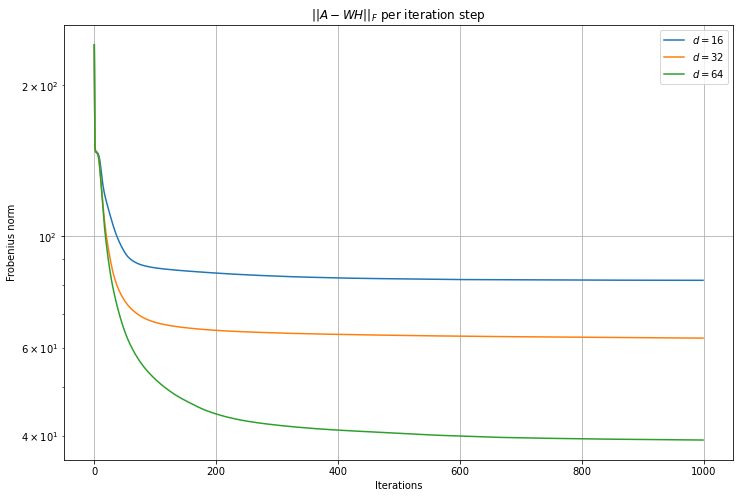

In [18]:
plt.figure(figsize = (12,8))
maxiter = 1000
legends = []

for d in [16, 32, 64]:
    result = NMF(faces_reshaped,d, maxiter=maxiter)
    plt.semilogy(np.arange(maxiter), result[2])
    legends.append(f"$d = {d}$")

plt.title(r"$||A - WH||_F$ per iteration step")
plt.xlabel("Iterations")
plt.ylabel("Frobenius norm")
plt.legend(legends)
plt.grid()

We observe from the plot that the general results are as expected. The error decreases when $d$ increases, because we include more information (see subsection "Accuracy and Convergence of NMF" for details). From the plot we can also assume that the algorithm has converged for $d = 16, 32$. It looks as though the slope still is less than $0$ at $1'000$ iterations, however the improvements from here would only be minor. The same can not be said for $d = 64$, substantiating the observation that when using larger values for $d$, the algorithm requires more iterations to converge.


Similar to the plot above, we can extract only the end result of the norm when we run the algorithm for different values of $d$. We run NMF with the same number of `maxiter` so the values are comparable. If we plot the result, we obviously expect the norm to decrease with increasing $d$.

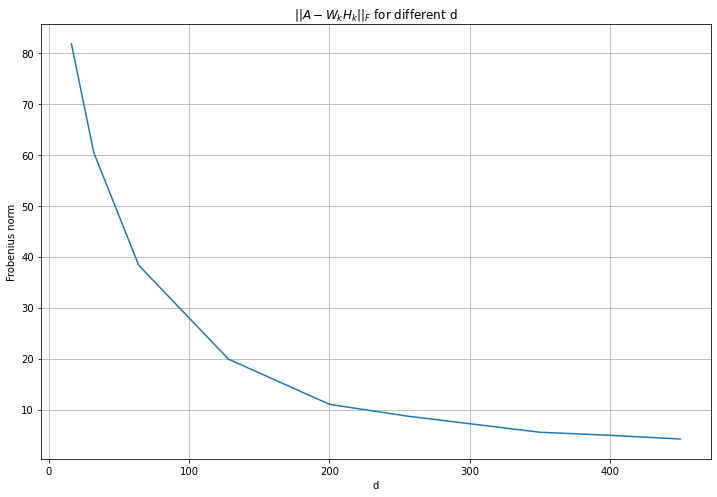

In [19]:
maxiter = 1500
y_clean = []
ds = [16, 32, 64, 128, 200, 256, 350, 400, 450]
for d in ds:
    result = NMF(faces_reshaped, d, maxiter=maxiter)
    y_clean.append(result[2][-1])

plt.figure(figsize = (12,8))
plt.plot(ds, y_clean)
plt.title(r"$||A - W_k H_k||_F$ for different d")
plt.xlabel("d")
plt.ylabel("Frobenius norm")
plt.grid()

The conclusion of the earlier discussion becomes even more apparent in this plot. We have included even more values of $d$ here, and the results are coherent with what we found previously as the end norm decreases when $d$ increases.

Another interesting note is that, in order for the results where $d > rank(A)$ to make sense, there should be a "separation" at $d = rank(A)$. Let us elaborate further. We remember from the previous plot, where $d$ was far lower than the rank, that the algorithm converged faster for lower values of $d$. However, as noted, the minimas they reached were very different; larger values of $d$ can represent the original matrix more accurately and thus reach lower minimas. The somewhat surprising element from this plot is that even though we have used the same `maxiter` for all the different runs, the norm for $d > rank(A)$ decreases with increasing $d$. Remembering our previous discussions, this does not make perfect sense. When $d < rank(A)$ there is no way to arrange $W$ and $H$ so that $WH$ = $A$. However, once we set $d \geq rank(A)$ there suddenly becomes many ways to represent $A$ in terms of $W$ and $H$. Consequently, with these values of $d$, the algorithm should converge to the same minima, that is $\|A - WH\|_F = \delta$. Hence, larger values of $d$ seem to converge faster since they attain a lower norm in our plot and we know they should converge to the same value. This is not coherent with $d < rank(A)$, where lower values of $d$ converge faster, yielding a "separation".

Our belief is that this "separation" occurs as a consequence of in how many ways $W$ and $H$ can represent $A$. It makes sense that when $rank(A) < d_1 < d_2$, the factorization that includes $d_2$ basis vectors has more ways to represent $A$ compared to the one using $d_1$. More values means more possible combinations (minimas), thus the algorithm on average requires less iterations to converge to a minima. The only way to quantitatively examine these notions is actually running the algorithm for $d \geq rank(A)$ and `maxiter` so that convergence is achieved. We attempt `maxiter` $= 10´000$ for $d \in [256, 385, 450]$, that is a $d = rank(A)$ and a value well on both sides.

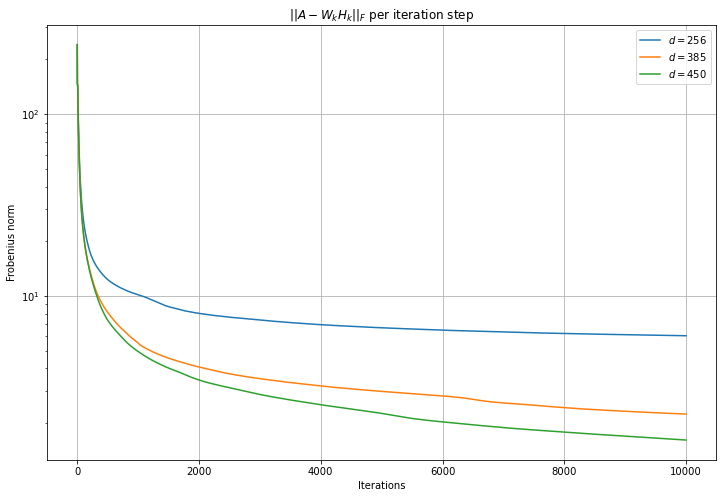

In [20]:
plt.figure(figsize = (12,8))
maxiter = 10000
legends = []

for d in [256, 385, 450]:
    result = NMF(faces_reshaped, d, maxiter=maxiter)
    plt.semilogy(np.arange(maxiter), result[2])
    legends.append(f"$d = {d}$")

plt.title(r"$||A - W_k H_k||_F$ per iteration step")
plt.xlabel("Iterations")
plt.ylabel("Frobenius norm")
plt.legend(legends)
plt.grid()

Clearly, the algorithm has far from converged in any of the cases. For $d = 450$, the one with the lowest norm at $10´000$ iterations, we estimate that $\|A - WH\|_F \approx 10^{0.1} \approx 1.26$. As mentioned, we expect it to converge to $\delta = 10^{-9}$. In other words, the norm should be reduced by a factor of approximately $10^9$ from 10´000 iterations, before it has converged. This would obviously take a ridiculous amount of iterations, however it is still possible to learn something from the plot. It looks as though the blue line converges faster and to a higher norm, as expected. Also, if $d = rank(A)$ and $d = 450$ actually do converge to the same value, the larger value does indeed converge faster, as postulated. As we know, the theory behind NMF is a bit lacking, and we do not have any proof that that the algorithm will converge to a norm of approximately $\delta$ for $d \geq rank(A)$. Nevertheless, to get anything out of this plot, we have to assume this. And even though we can not conclude with anything in particular, our earlier observations are not debunked by these results.

## NMF and denoising

### Adding noise

Until now, we have only worked with perfect data. We ran the NMF-algorithm on an input matrix where all datapoints were as desired. In the real world however, this is rarely the case. Noise of some sort usually occur in all sorts of data, for different reasons. We would like to test the NMF-algorithm on more and more "realistic" input matrices, and observe the results as before. To do this, we utilize additive Gaussian noise where we define a new matrix as

$$
\begin{aligned}
A_{noisy} = A + \sigma E.
\end{aligned}
$$

Here $\sigma$ is a scalar which represents the noise level and $E$ is a matrix with the same dimensions as $A$ where all elements are calculated from a standard normal distribution. For simplicity we will assume the opacity values are known, and don't have any noise. Also, only non-zero color channels will have noise. We use the provided function `add_noise()` to generate a matrix $A_{noisy}$.

We will use $\sigma = 0.1$ throughout the rest of this project, a considerably high value, to really witness the effects of noise. Under the definition of `add_noise()` we have plotted an $8 \times 8$ grid, just as for the original faces but now with noise and $\sigma = 0.1$. We also plot a large example, to provide a more detailed visualization of the amount of disturbance. These images are the result of using the `add_noise()` function on a big $24\cdot24\cdot3 \times 500$ matrix. Additionally, we print the norm $||A_{noisy} - A||_F$, that will be used later.

In [21]:
def add_noise(imgs_reshaped, sigma = 0.1):
    """
    Adds gaussian noise to images as described in text.
    Note that imgs must be given as a (24*24*3, N) numpy array, i.e the reshaped images
    Input:
        imgs_reshaped: (1728,N) numpy array
        sigma: scalar, noise level
    Output:
        noisy_faces: (1728,N) numpy array containing noisy images
    """
    # Noise level
    sigma = 0.1

    # Array that will store the rgb channels of the noisy images
    noisy_faces = np.copy(imgs_reshaped)

    # Number of noisy values we need
    nnzero = faces_reshaped[np.nonzero(imgs_reshaped)].shape[0]

    # Sample noisy values and add noise
    noise = np.random.normal(0.0,1,nnzero)
    noisy_faces[np.nonzero(imgs_reshaped)] += sigma*noise

    # Clip to lie between 0 and 1 so that we can still interpret them as images
    noisy_faces = np.maximum(0.0,np.minimum(1.0, noisy_faces))

    return noisy_faces

In [22]:
def plot_detail(imgs, title, layout, size = 10):
    """
    Plot faces in detail (bigger axes)
    """
    fig, axes = plt.subplots(layout[0],layout[1], figsize=(size, size))
    
    if layout[0] == 1:
        for idx, arr in enumerate(imgs):
            axes[idx].set_title(title[idx], fontsize = 25)
            axes[idx].axis('off')

            # Rescale RGB channels by dividing my maximal value
            scaled_img = np.copy(arr[:,:,:])
            scaled_img[:,:,:3] = scaled_img[:,:,:3]/np.max(scaled_img[:,:,:3])
            axes[idx].imshow(scaled_img)

        plt.tight_layout()
        plt.show()
    else:
        col = 0
        row = 0
        for idx, arr in enumerate(imgs):
            axes[row,col].set_title(title[idx], fontsize = 25)
            axes[row,col].axis('off')

            # Rescale RGB channels by dividing my maximal value
            scaled_img = np.copy(arr[:,:,:])
            scaled_img[:,:,:3] = scaled_img[:,:,:3]/np.max(scaled_img[:,:,:3])
            axes[row,col].imshow(scaled_img)

            if (idx+1)%layout[1] == 0 and idx != 0:
                col = 0
                row += 1
            else:
                col += 1

        plt.tight_layout()
        plt.show()

||A_noisy - A||_F = 41.93


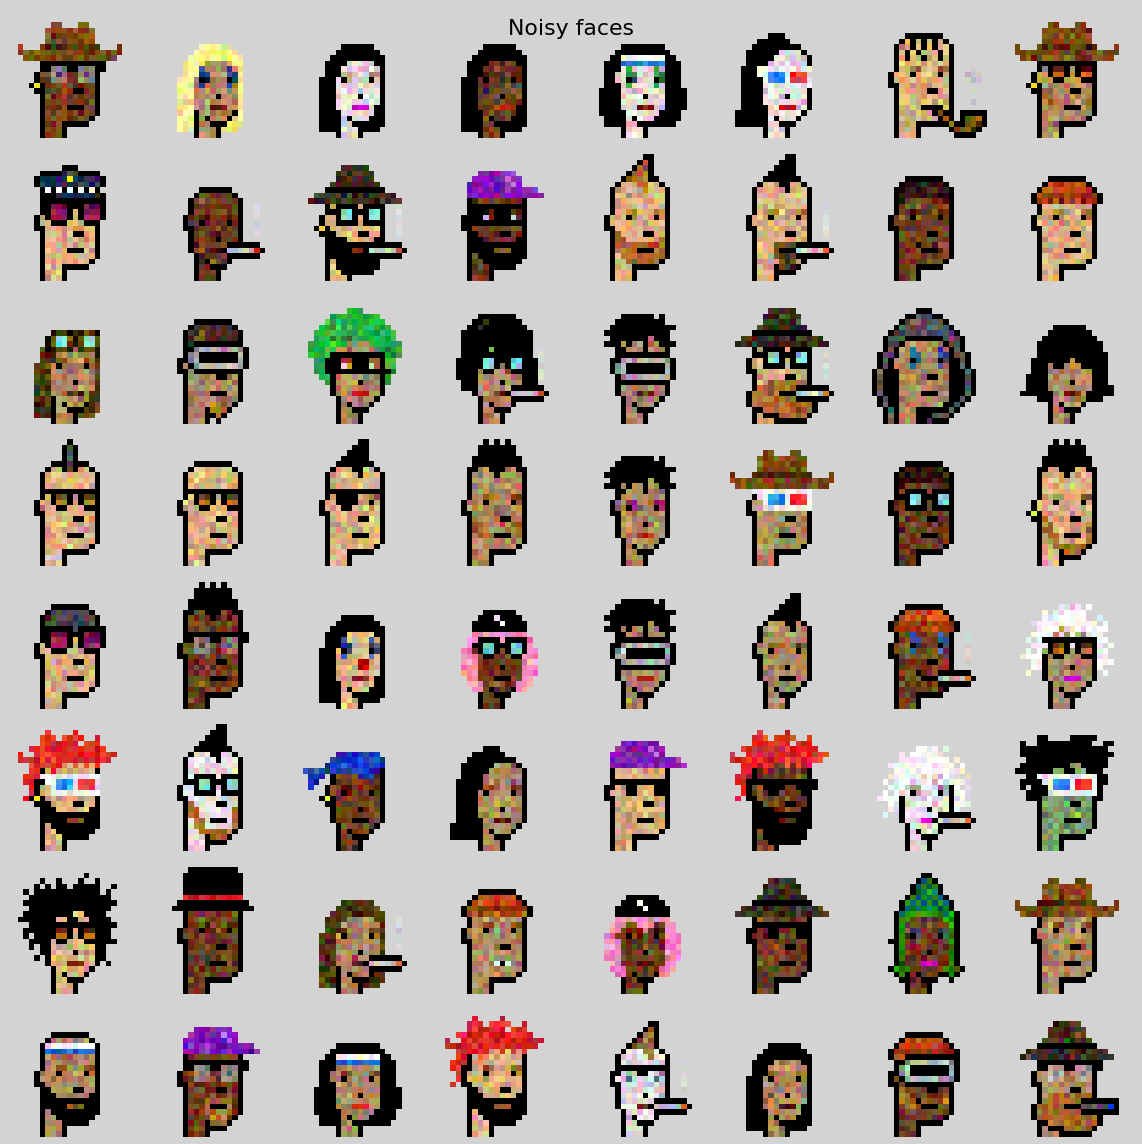

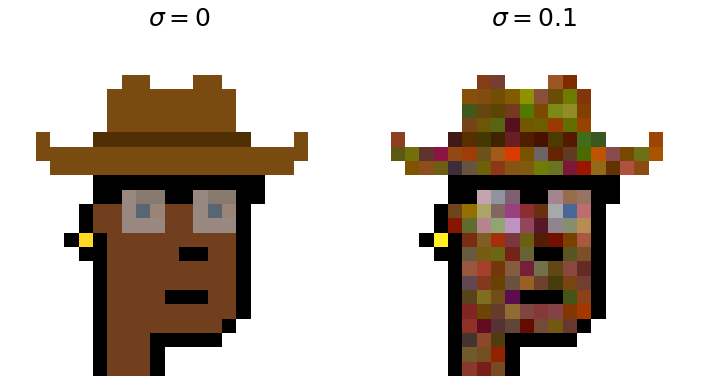

In [23]:
noisy_faces = add_noise(faces_reshaped)

# Calculate the error of the noisy images
noise_residual = np.linalg.norm(noisy_faces - faces_reshaped, 'fro')
print("||A_noisy - A||_F =", round(noise_residual, 2))

# For plotting noisy images we add the opacity
noisy_faces_with_opacity = np.zeros(faces.shape)
noisy_faces_with_opacity[:,:,:3,:] = noisy_faces.reshape(faces_rgb.shape)
noisy_faces_with_opacity[:,:,3,:] = faces_opacity
plotimgs(noisy_faces_with_opacity, "Noisy faces")

# ---------------------
# LARGE IMAGE

# Get examples
example = faces_reshaped[:,0]
noisy_example = add_noise(example)

# Reshape
example_reshaped = np.clip(example.reshape(24,24,3,1),0,1)
noisy_example_reshaped = np.clip(noisy_example.reshape(24,24,3,1),0,1)

# Add opacity
example_final = np.insert(example_reshaped[:,:,:,0], 3, faces_opacity[:,:,0], axis = 2)
noisy_example_final = np.insert(noisy_example_reshaped[:,:,:,0], 3, faces_opacity[:,:,0], axis = 2)

# Plotting
plot_detail([example_final, noisy_example_final], ["$\sigma = 0$", "$\sigma = 0.1$"], (1,2))

We can clearly see the effect of the added noise, however us humans can still pick up on the most important patterns from the noisy image. We can still observe the golden earring and that he is wearing a hat. Our hope is that the NMF algorithm also manages to pick up on these patterns. As discussed earlier, the columns of $W$ in $A \approx WH$ are the eigenvectors of A. When we attempt to dimensionally reduce the data in our original matrix, the algorithm should prioritize the original images. It does not make sense to have noise as eigenvectors, after all it's just noise. The algorithm "picks up on" attributes that occur across multiple images, and noise is not an attribute or a pattern, it's randomly generated.

### Applying NMF to the noisy images

With our $24\cdot24\cdot3 \times 500$ noisy matrix ready, we can run the NMF algorithm. We choose the conditions (maxiter and d) the same as earlier for the results to be comparable. We plot both the reconstructed images and the columns of $W$ below.

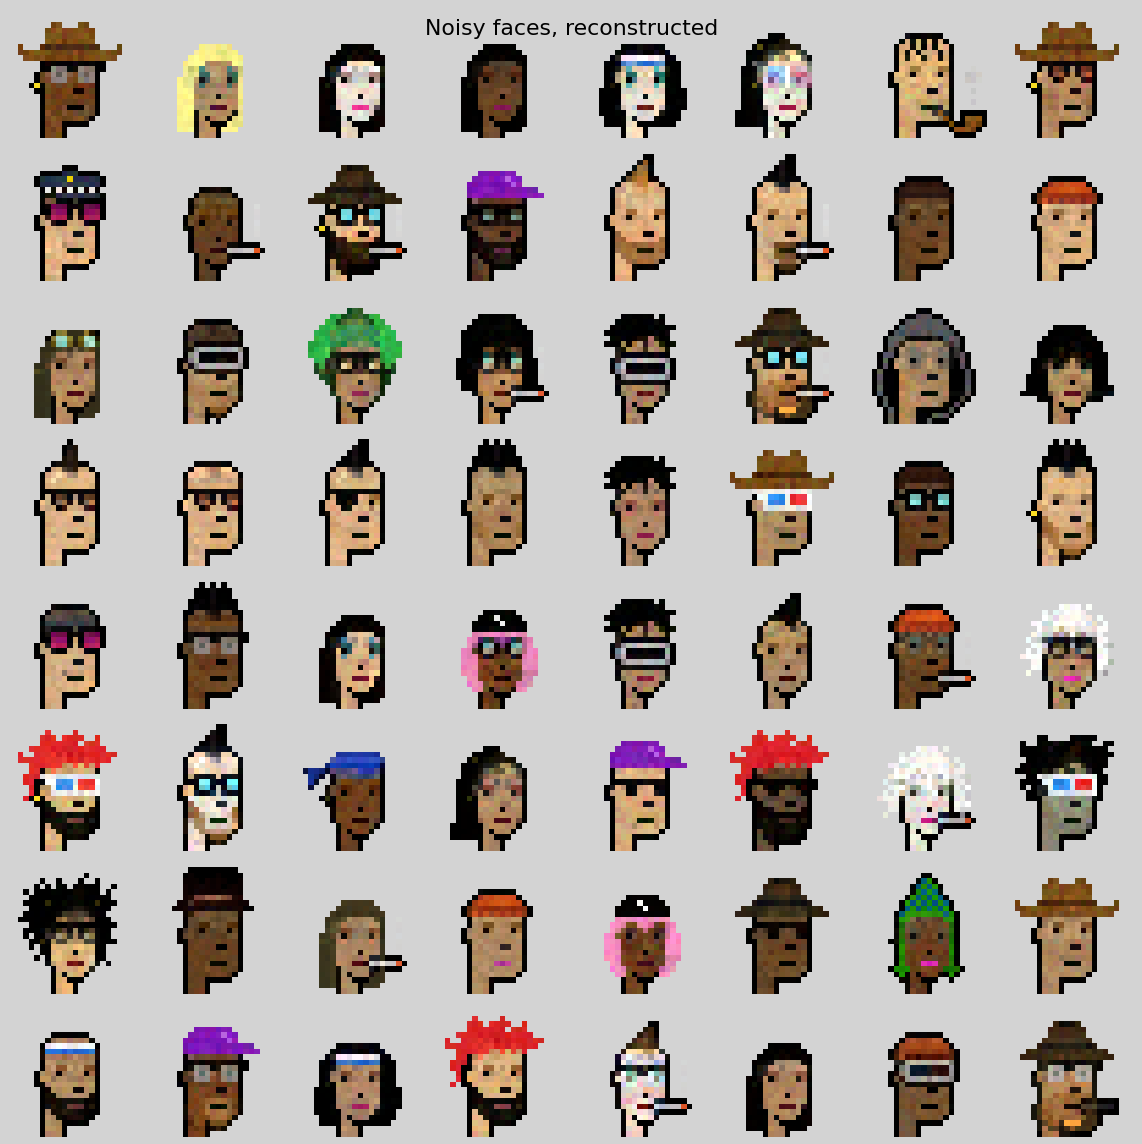

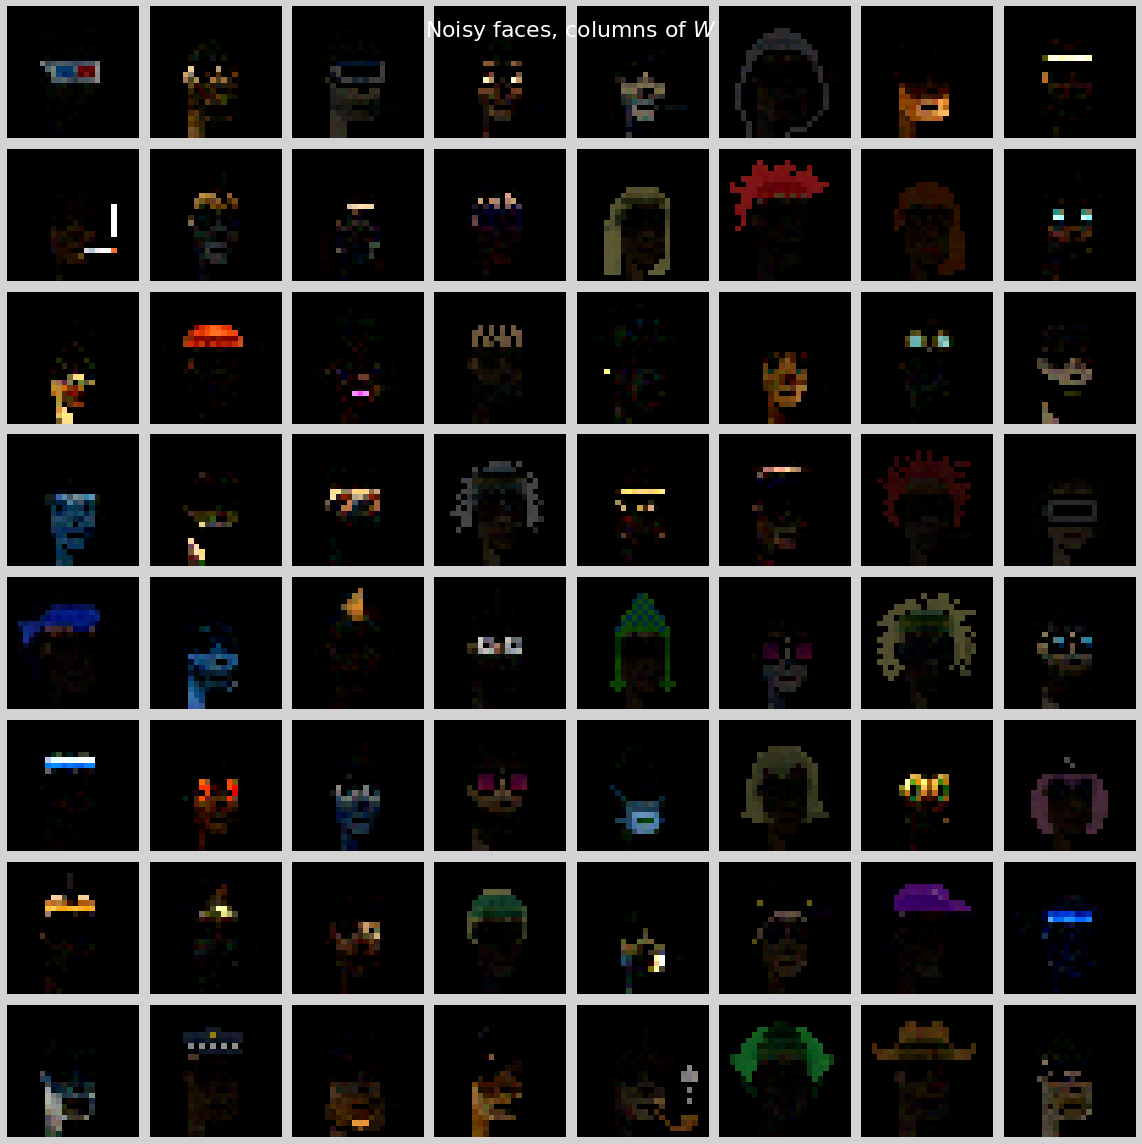

In [24]:
d = 64

# Faces
result_noisy = NMF(noisy_faces,d, maxiter=1000)
A_rec_noisy = result_noisy[0] @ result_noisy[1]
noisy_punks_rec = np.clip(A_rec_noisy.reshape(24,24,3,N),0,1)
noisy_punks_rec_opa = np.insert(noisy_punks_rec, 3, faces_opacity, axis = 2)

# Columns
NMF_faces_reshaped = np.clip(result_noisy[0].reshape(24,24,3,d),0,1)

# Plotting
plotimgs(noisy_punks_rec_opa, "Noisy faces, reconstructed")
plotimgs(NMF_faces_reshaped, "Noisy faces, columns of $W$", "w")

At first glance, the basis vectors look very similar to the ones. In particular, the distinct features are strikingly interchangeable. Looking at the orange hat, the purple cap or the red hair they are almost identical to the previous ones. The clearest distinction is the faces. The "basis faces" here generally has a bit more noise; quite a few pixels are miscolored. This was not the case for the noiseless basis vectors. To compare further, we plot the reconstructions in more detail.

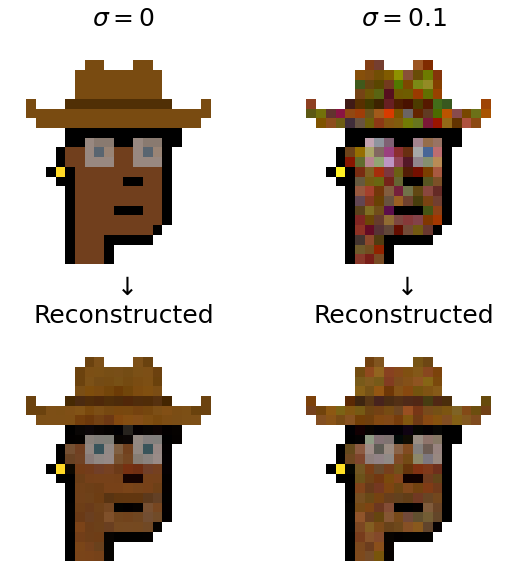

||A_noisy_rec - A||_F = 42.57
||A_noisy_rec - A_rec||_F = 28.5


In [25]:
example_noisy_rec = noisy_punks_rec_opa[:,:,:,0]
example_rec = punks_rec_opa[:,:,:,0]

# Plot
plot_detail([example_final, noisy_example_final, example_rec, example_noisy_rec],
            ["$\sigma = 0$", "$\sigma = 0.1$", "$\downarrow$\nReconstructed", "$\downarrow$\nReconstructed"], (2,2), 8)

print("||A_noisy_rec - A||_F =", round(np.linalg.norm(A_rec_noisy - faces_reshaped, 'fro'), 2))
print("||A_noisy_rec - A_rec||_F =", round(np.linalg.norm(A_rec_noisy - A_rec, 'fro'), 2))

From the plot above, the result of the denoising is more comparable. Comparing it to the original image would be unfair, since the reconstructed images that used the "perfect data" also have some faults. If we look at the two reconstructions above, they are surprisingly similar considering the data they used. With no background knowledge it would almost seem like magic that the "perfect" and "noisy" data could produce such similar results. We can still determine some imperfections in the reconstructions, but they are mostly similar to the ones that the original reconstruction has. 

The general patterns are recreated very well. The most apparent fault (for both cases) is the miscoloring of the skin. However, remembering our previous discussion about distinct features, and our recent observations from the columns of $W$, this is not surprising at all. The skin is generally not a "distinct feature", it's something that always is there, and the skin tone varies a bit from punk to punk.

These observations are also reflected in the norms we calculate. From earlier, we remember that $\|A_{noisy} - A\|_F = 41.93$. After using NMF and reconstructing the image, we get $\|A_{noisy, rec} - A\|_F = 42.57 \approx \|A_{noisy} - A\|_F$. This result in itself is not of that much interest, because in the noisy case, the reconstruction and the original are very different. Yet it could still be worth noting that this number does not increase drastically. What is more interesting is that $\|A_{noisy, rec} - A_{rec}\|_F = 28.5 < \|A_{noisy} - A\|_F$. In other words, the difference in the reconstructions is less than the difference in the original images. These quantitative results support our previous remarks and points to a reduction in noise. Still, do not forget that the Frobenius norm is not necessarily the best way to interpret a difference in matrices that represent images, and that these numbers should be taken with a grain of salt (see project description for details).

To summarize, the denoising definitely seems to work. The reconstructed images using the noisy data are not far off the reconstructed images using the original data. Also the features that are reconstructed accurately and less accurately are the same in both cases. Additionally, it is important to remember that we have only used $5$% of the available data in these experiments ($500$ of $10'000$ images). If we had used more data, a higher `maxiter` and a larger $d$ the results would most likely have been even more similar and accurate.

### Convergence - Underfitting and overfitting

Just as before, to get an even more precise view of how good the reconstructions are, we can use the Frobenius norm to calculate a "distance" between the original matrix and the reconstructions. In this case we have used $d = 64$, but we run the algorithm for different values of $d$ and compare the results.

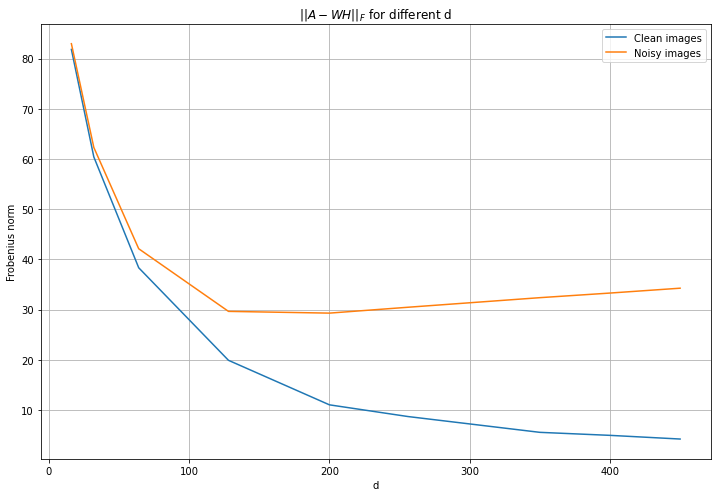

In [26]:
maxiter = 1500
y_noisy = []
ds = [16, 32, 64, 128, 200, 256, 350, 400, 450]
for d in ds:
    result_noisy = NMF(noisy_faces, d, maxiter=maxiter, A_orig = faces_reshaped)
    y_noisy.append(result_noisy[2][-1])

plt.figure(figsize = (12,8))
plt.plot(ds, y_clean)
plt.plot(ds, y_noisy)
plt.title(r"$||A - WH||_F$ for different d")
plt.xlabel("d")
plt.ylabel("Frobenius norm")
plt.legend(["Clean images", "Noisy images"])
plt.grid()

When initially looking at the plot, it seems that the results are more accurate when we increase $d$, the number of columns in $W$, as expected (NB: The blue line is the same as in the previous similar plot). However there are a few additional things that are worth noting from this plot. 

Firstly, the lines seem to follow each other for lower values of $d$. In other words, when we compress the data a lot the results are very similar. Below is a visualization of these results.

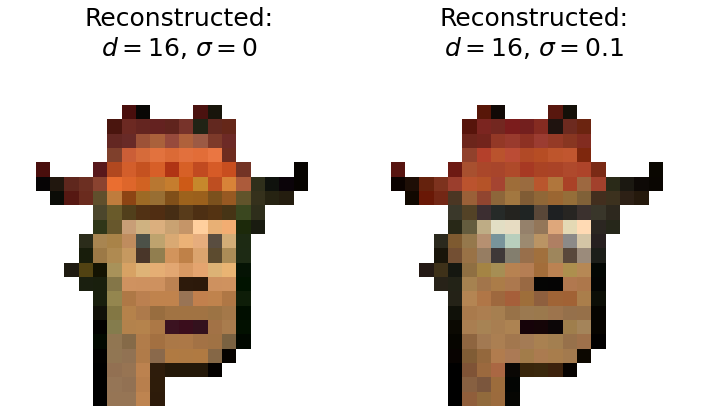

In [27]:
d = 16
maxiter = 1500
results_small = [NMF(noisy_faces,d, maxiter=maxiter), NMF(faces_reshaped,d, maxiter=maxiter)]

# Clip and reshape
noisy_small = np.clip((results_small[0][0] @ results_small[0][1]).reshape(24,24,3,500),0,1)
clean_small = np.clip((results_small[1][0] @ results_small[1][1]).reshape(24,24,3,500),0,1)

# Add opacity
noisy_small = np.insert(noisy_small[:,:,:,0], 3, faces_opacity[:,:,0], axis = 2)
clean_small = np.insert(clean_small[:,:,:,0], 3, faces_opacity[:,:,0], axis = 2)

plot_detail([clean_small, noisy_small],
            ["Reconstructed:\n$d=16$, $\sigma = 0$", "Reconstructed:\n$d=16$, $\sigma = 0.1$"], (1,2))

The reason for the similarity is not very simple, it comes down to how the algorithm prioritizes. However, the intuition behind it does not have to be very complicated. When we use $d = 16$, we reduce the amount of data by approximately $96$%. Therefore, the algorithm really has to "choose" the data that carries the most "weight". Noise obviously carries very little information; hence it is placed at the bottom of the prioritization ladder. This way the deviation between noisy and clean images is very small; little of the noise makes it into the data compression. Nonetheless, the results are not impressive.

Secondly, when we increase the value of $d$, the difference in accuracy increases accordingly. Especially when $d > 64$ the deviation becomes clear. The reason is similar to why the difference was small earlier; how much noise is recorded in the compression. Even though the reconstructions obviously are better, the difference is greater because the "noise-free" one has a steeper improvement-curve.

Finally, in conjunction with our previous observation, the norm actually increases for $d > d_{optimal}$ where $d_{optimal}\in\Bbb N\cap[128,256]$ 
(a very rough estimation due to the the large interval i $d$ in our plot). Like we discussed earlier, larger $d$ means more noise, and at some point we include too much noise. This is a common problem known as overfitting and underfitting. When we choose $d$ excessively low, too much information is lost. In contrast, if we choose $d$ excessively large, too much noise is included.

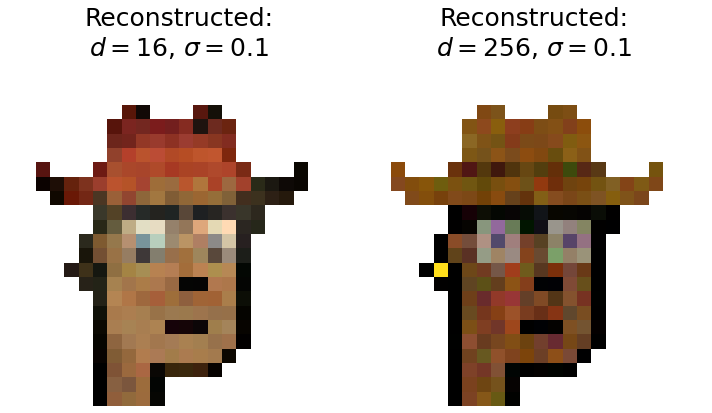

In [34]:
result_noisy = NMF(noisy_faces,256, maxiter=1500)
result_noisy = np.clip((result_noisy[0] @ result_noisy[1]).reshape(24,24,3,500),0,1)
result_noisy = np.insert(result_noisy[:,:,:,0], 3, faces_opacity[:,:,0], axis = 2)
plot_detail([noisy_small, result_noisy],
            ["Reconstructed:\n$d = 16$, $\sigma = 0.1$", "Reconstructed:\n$d=256$, $\sigma = 0.1$"], (1,2))

Above is a plot of the extreme points of the scale; $d=16$ and $d=256$. Looking at these punks, the terms overfitting and underfitting should bring some intuition. The plot on the left (same as before) lacks important information. Note for instance how the earring and the glasses are completely absent. We can conclude that the image is underfitted. On the contrary, the right plot includes too much information, and therefore has clear noise. This is especially apparent in the skin. The righthand image seems to be overfitted. The concept of overfitting opposed to underfitting becomes particularly evident if we look at the cryptopunks throat. When $d = 16$ the throat is actually much more precisely reconstructed.

Our current estimation is as mentioned very rough. Hence we have included a function `bisection_d()` that utilizes the bisection method to get a much better approximation of $d_{optimal}$. We set the tolerance to $10$, to get decent runtimes, but also because the precise value is not of that much interest. We are primarily in the region in which we find $d_{optimal}$.

In [32]:
def bisection_d(d_min, d_max, tol=10, max_iter = 10):
    """
    Finds optimal d to minimize error in reconstruction
    d_min: Minimal value for d (int)
    d_max: Maximal value for d (int)
    
    returns: d_optimal (int)
    """
    result_min = NMF(noisy_faces,d_min,maxiter=1000, A_orig = faces_reshaped)[2][-1]
    result_max = NMF(noisy_faces,d_max,maxiter=1000, A_orig = faces_reshaped)[2][-1]
    
    for k in range(max_iter):
        
        # Finds middle value
        d_mid = int(0.5*(d_min + d_max))
        result_mid = NMF(noisy_faces,d_mid,maxiter=1000, A_orig = faces_reshaped)[2][-1]
        
        print(f"i ={k:3d}, d_min = {d_min:.1f}," 
        f"d_max = {d_max:.1f}, d_mid = {d_mid:.1f}")

        if abs(d_min - d_max) < tol:                          # Presicion acquired
            break
        elif result_mid > result_max:
            result_min = result_mid                           # d too low
            d_min = d_mid
        else:                                                 # d too high
            result_max = result_mid
            d_max = d_mid

    return d_mid

In [33]:
d_optimal = bisection_d(128,256)

i =  0, d_min = 128.0,d_max = 256.0, d_mid = 192.0
i =  1, d_min = 128.0,d_max = 192.0, d_mid = 160.0
i =  2, d_min = 160.0,d_max = 192.0, d_mid = 176.0
i =  3, d_min = 160.0,d_max = 176.0, d_mid = 168.0
i =  4, d_min = 168.0,d_max = 176.0, d_mid = 172.0


The bisection method yields $d_{optimal} = 172 \pm 4$. Obviously we do not know if this result is exact. For all we know there may be fluctuations in the area surrounding this value, and there may be bigger minimas just outside our uncertainty interval. However, the results are sufficient regarding the objectives of this project. Using this value for $d$, we can compare the results of the reconstructions with the ones where we found that there was underfitting and overfitting. To emphasize the differences we use $d = 450$ for the overfitted model this time.

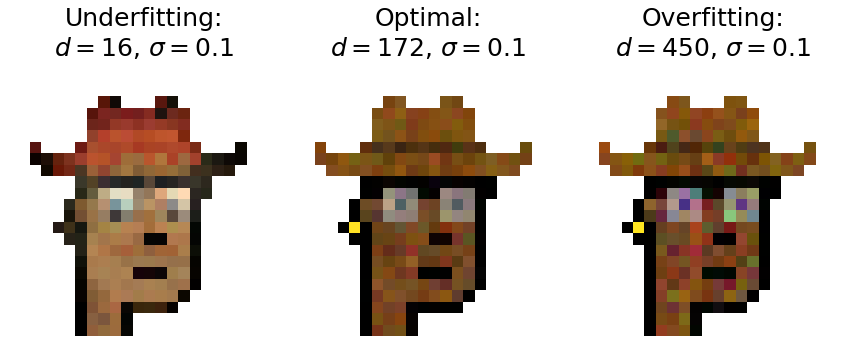

In [35]:
result_optimal = NMF(noisy_faces,d_optimal, maxiter=1500)
result_optimal = np.clip((result_optimal[0] @ result_optimal[1]).reshape(24,24,3,500),0,1)
result_optimal = np.insert(result_optimal[:,:,:,0], 3, faces_opacity[:,:,0], axis = 2)

result_noisy = NMF(noisy_faces,450, maxiter=1500)
result_noisy = np.clip((result_noisy[0] @ result_noisy[1]).reshape(24,24,3,500),0,1)
result_noisy = np.insert(result_noisy[:,:,:,0], 3, faces_opacity[:,:,0], axis = 2)

plot_detail([noisy_small, result_optimal, result_noisy],
            ["Underfitting:\n$d = 16$, $\sigma = 0.1$",
             f"Optimal:\n$d={d_optimal}$, $\sigma = 0.1$", "Overfitting:\n$d=450$, $\sigma = 0.1$"], (1,3), 12)

The results are as expected. Of these, $d = d_{optimal}$ yields the best result. We can clearly see how the fairly exaggerated plot with $d = 450$ includes much more noise. On the contrary the leftmost plot lacks many details, as previously mentioned. Visually $d_{optimal}$ represents a balance between details and noise.

An interesting note is that at $d = d_{optimal}$ there is a considerable amount of noise. However, if we remember our original reconstruction at $d = 64$ there was already quite a bit of noise. And if we were to compare with the original noisy image, a lot of the noise is indeed removed. Also remembering that we are only using $500$ images, and `maxiter` $= 1500$, the results are not that unflattering. We remember from earlier that convergece potentially could require many, many more iterations. If we were to use all $10'000$ images and a higher `maxiter` the reconstructions would most likely be much better. But to attain this, `maxiter` would have to be of a different order of magnitude.

## Summary and Conclusion

We started this project by implementing the non-negative matrix factorization method and proceeded to look at some of its properties. The main things we found were that the convergence and accuracy of the algorithm is highly dependent on the original matrix $A$, the number of dimensions $d$, and the initial matrices $W_0$ and $H_0$. For our value of $d$, we found that as long as $d\geq\text{rank}(A)$, the end norm will converge towards $\|A-W_kH_k\|\approx \delta=10^{-9}$, but that the number of iterations required may vary depending on $A$, $W_0$ and $H_0$. For $d<\text{rank}(A)$ we simply do not have enough dimensions to represent $A$ perfectly, and the algorithm will converge to a larger end norm.

Next, we used the NMF method on the CryptoPunk dataset. After representing the images in matrices, we discovered that many of the columns were linearly dependent. According to what we found in the first section, this indicated that we should be able to compress the images without major losses. After running the algorithm, it became clear how it was possible to visually interpret the columns of $W$ in $A \approx WH$. The columns represented different features of the CryptoPunks, for instance hats, glasses, hairstyles etc. We discovered how more distinct features (i.e. bright, with sharp edges) were better filtered out.

We subsequently reconstructed the images, utilizing $A \approx WH$. The results were very interesting and proved our earlier assumptions correct. The reconstructed images generally contained all the different features satisfyingly represented. The reconstructions were also coherent with our observations from the columns of $W$, as more distinct features were more accurately recreated. We also found, coherent with our previous observations, that the results were very dependent on the value of $d$. Moreover, in order for the algorithm to reach a minima, it would require an immense amount of iterations when $d$ was sufficiently large. Although the reconstructions were far from perfect, we found the results quite impressive considering the amount of data reduction and the fact that we only used $5$% of the available data.

In the final third of the project, we looked into the NMF algorithm's denoising effects. We first applied noise to the original images and ran the NMF algorithm on this new matrix containing noise. We found the outcome generally quite successful. When using $d = 64$ there was clearly a loss of noise in the CryptoPunk characters. Furthermore, we found, when looking into the Frobenius norm comparing the resulting matrix and the original one, there existed a $d$ that yields the optimal result. We discovered how this was connected to the concepts of underfitting and overfitting, a well-known problem. We then finally attempted to estimate the optimal $d$ and compare results when running the algorithm for an underfitted, overfitted and optimal model. Even though we concluded that it was difficult to determine a specific value for $d_{optimal}$, we clearly saw how our estimate was a middle ground between many details and little noise. This being said, there was a considerable amount of noise for $d = d_{optimal}$. We concluded that in order to fix this, runtimes would be unmanageable.

In conclusion, the NMF algorithm has its advantages and disadvantages. When utilizing NMF on images, the effects of the algorithm is easy to visualize. We remember how the columns of $W$ clearly represented different traits and features. Furthermore, the results, especially considering the denoising, were by large fairly impressive. However, when using NMF we found that for the results to be really satisfactory, runtimes would be unmanageable. Additionally it can be difficult to determine for which matrices the algorithm converges, and how it behaves. Moreover, the convergence rate can be hard to predict and is sometimes incredibly slow. These disadvantages become even more apparent due to the lack of documentation behind the algorithm, and the existence of such in other cases. We know there are other algorithms (i.e. SVD) that would most likely be able to produce more imposing results. However these methods would not be as easy (or possible at all) to visually interpret, because they are not non-negative.